### Convert to Binary Image:
Use image processing software (e.g., ImageJ, Python, MATLAB) to threshold the image and create a binary mask where pores are white (1) and the polymer film is black (0).

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure

image_path = 'sample2A.jpg'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Preprocess the image (thresholding to highlight pores)
_, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV)

# Find contours of the pores
contours = measure.find_contours(binary_image, 0.8)

# Extract centroids of the pores
centroids = []
for contour in contours:
    M = cv2.moments(contour)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])  # X-coordinate of centroid
        cy = int(M["m01"] / M["m00"])  # Y-coordinate of centroid
        centroids.append((cx, cy))

centroids = np.array(centroids)

In [3]:
print(centroids)

[[0 2]
 [0 1]
 [0 1]
 ...
 [0 1]
 [0 0]
 [0 0]]


 ## Extract Droplet Centroids

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image in grayscale
image_path = "sample4A.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply a Gaussian blur to reduce noise
blurred = cv2.GaussianBlur(image, (3, 3), 0)

# Use Otsu's thresholding to segment pores
_, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Perform morphological opening to remove noise
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)

# Detect connected components
num_labels, labels = cv2.connectedComponents(cleaned)

# Compute centroids
centers = []
for label_id in range(1, num_labels):  # Skip label 0 (background)
    mask = (labels == label_id).astype(np.uint8)
    M = cv2.moments(mask, binaryImage=True)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        centers.append((cX, cY))

# Convert grayscale to BGR for drawing
marked_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
print(centroids)
plt.imshow(image, cmap='gray')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=5)
plt.title('Detected Droplet Centers')
plt.show()



NameError: name 'centroids' is not defined

[[ 47 513]
 [265 511]
 [143 501]
 [594 491]
 [354 487]
 [448 486]
 [791 481]
 [877 460]
 [ 15 462]
 [309 443]
 [685 459]
 [219 442]
 [517 445]
 [ 99 424]
 [401 412]
 [  0 364]
 [778 398]
 [628 379]
 [854 358]
 [303 347]
 [538 339]
 [706 329]
 [184 333]
 [437 304]
 [ 64 306]
 [793 288]
 [626 277]
 [356 254]
 [255 242]
 [523 233]
 [149 224]
 [859 227]
 [714 218]
 [429 188]
 [ 48 184]
 [617 166]
 [224 144]
 [328 152]
 [799 147]
 [512 132]
 [131 119]
 [882 111]
 [ 28  79]
 [421  76]
 [700  78]
 [586  59]
 [315  46]
 [820  53]
 [506  12]
 [388   3]
 [203  46]
 [ 89  49]]


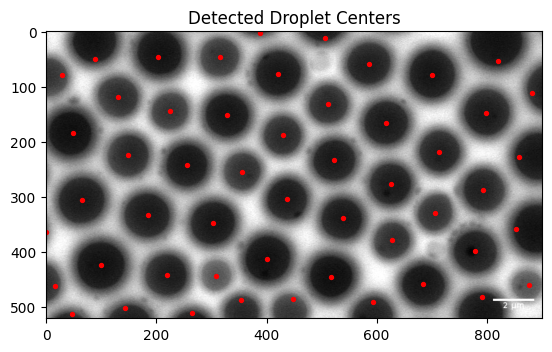

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image in grayscale
image_path = "sample4B.jpg"  # Update with your image path if needed
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply median blur to reduce noise
blurred = cv2.medianBlur(image, 5)

# Use Otsu's thresholding to create a binary mask
_, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Perform morphological closing to fill small gaps
kernel = np.ones((5, 5), np.uint8)
closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)

# Detect edges using Canny edge detector
edges = cv2.Canny(closed, 50, 150)

# Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Convert to color image for visualization
output_final = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Draw detected pore centers
centroids = []
for cnt in contours:
    M = cv2.moments(cnt)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        centroids.append((cx, cy))

# Convert to NumPy array
centroids = np.array(centroids)

print(centroids)
# Step 5: Plot the results
plt.imshow(image, cmap='gray')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=8)
plt.title('Detected Droplet Centers')
plt.show()

[[151 597]
 [278 596]
 [601 584]
 [806 561]
 [400 566]
 [702 540]
 [305 498]
 [ 10 466]
 [522 425]
 [205 358]
 [472 286]
 [374 260]
 [779 236]
 [814 152]
 [ 17  76]
 [367  62]
 [485  44]
 [704   5]
 [565  12]
 [280  24]
 [ 69  17]]


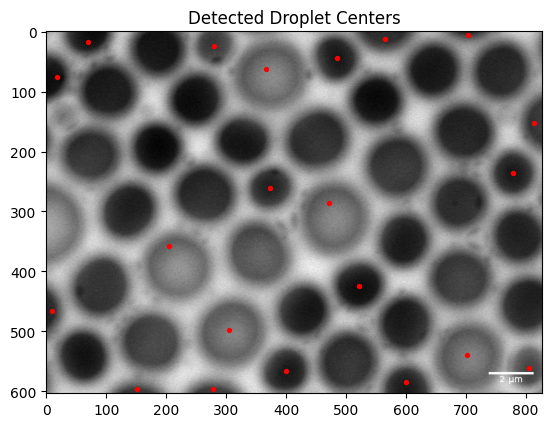

In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load SEM Image in Grayscale
image = cv2.imread('sample6B.jpg', cv2.IMREAD_GRAYSCALE)

# Step 1: Apply Gaussian Blur to reduce noise
blurred = cv2.GaussianBlur(image, (5, 5), 0)

# Step 2: Apply Otsu’s Thresholding for better segmentation
_, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Step 3: Morphological Operations to refine segmentation
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
morphed = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# Step 4: Find Contours and Filter by Area
contours, _ = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

centroids = []
min_area = 100  # Adjust to remove small noise
max_area = 5000  # Adjust to exclude large non-droplet objects

for contour in contours:
    area = cv2.contourArea(contour)
    if min_area < area < max_area:
        # Use Convex Hull to refine the droplet shape
        hull = cv2.convexHull(contour)
        M = cv2.moments(hull)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            centroids.append([cx, cy])

# Convert to numpy array
centroids = np.array(centroids)
print(centroids)
# Step 5: Plot the results
plt.imshow(image, cmap='gray')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=8)
plt.title('Detected Droplet Centers')
plt.show()


[[151 597]
 [278 597]
 [725 579]
 [730 574]
 [601 584]
 [806 559]
 [400 566]
 [503 550]
 [ 61 541]
 [698 535]
 [173 518]
 [307 500]
 [598 487]
 [ 10 466]
 [430 467]
 [796 455]
 [522 425]
 [ 90 426]
 [691 411]
 [485 356]
 [493 352]
 [497 351]
 [200 365]
 [509 343]
 [462 351]
 [512 339]
 [445 333]
 [353 369]
 [522 308]
 [597 349]
 [522 301]
 [788 341]
 [  7 268]
 [470 282]
 [138 298]
 [689 285]
 [374 260]
 [264 269]
 [779 236]
 [586 223]
 [  3 181]
 [ 75 204]
 [185 194]
 [327 183]
 [452 180]
 [697 168]
 [368 115]
 [814 152]
 [551 115]
 [249 113]
 [103  98]
 [ 17  76]
 [364  58]
 [826  29]
 [646  64]
 [759  65]
 [485  44]
 [705   5]
 [565  12]
 [280  24]
 [187  34]
 [ 69  17]]


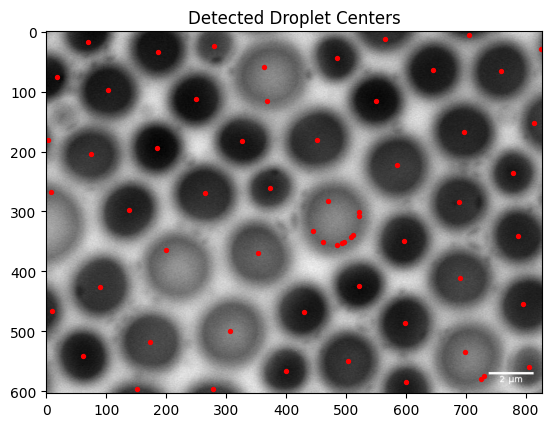

In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = "sample6B.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply Gaussian blur to smooth the image
blurred = cv2.GaussianBlur(image, (5, 5), 0)

# Apply thresholding to create a binary image
_, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Find contours
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a copy of the image to draw on
output = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Calculate and draw centroids
centroids = []
for contour in contours:
    M = cv2.moments(contour)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        centroids.append((cX, cY))
        cv2.circle(output, (cX, cY), 3, (0, 0, 255), -1)

# Show the output image with centroids
centroids = np.array(centroids)
print(centroids)
# Convert to NumPy array
# Step 5: Plot the results
plt.imshow(image, cmap='gray')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=8)
plt.title('Detected Droplet Centers')
plt.show()


## Perform Voronoi Tessellation

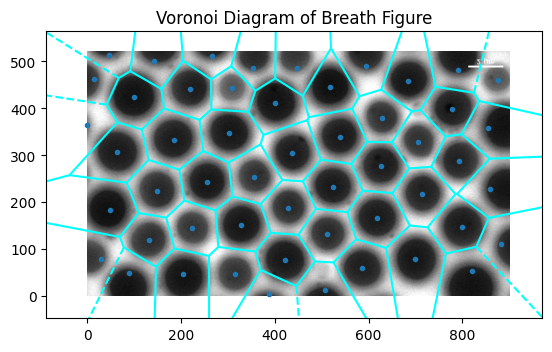

In [14]:
from scipy.spatial import Voronoi, voronoi_plot_2d

# Compute Voronoi Tessellation
vor = Voronoi(centroids)

# Plot Voronoi Diagram
fig, ax = plt.subplots()
ax.imshow(image, cmap='gray')
voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='cyan', line_width=1.5)
plt.title('Voronoi Diagram of Breath Figure')
plt.show()


## Analyze Voronoi Cell Shapes

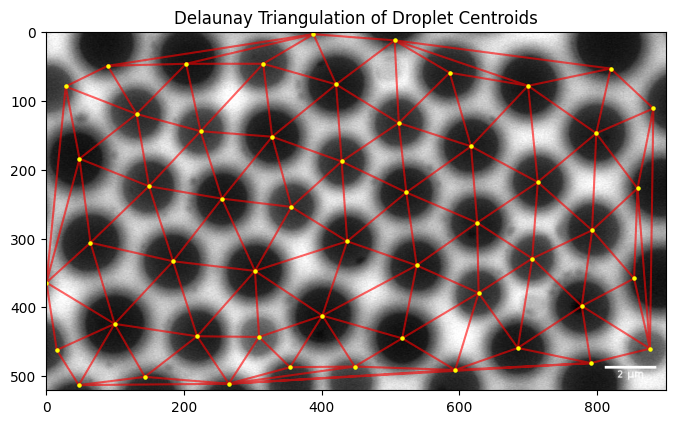

In [15]:
import cv2
import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt

# Load SEM Image
# Preprocess Image (assuming previous steps are done and centroids are detected)
# This part assumes that centroids are already identified, e.g., using contours or other method

# Example centroid array (replace with actual centroids)
# centroids = np.array([[100, 150], [200, 250], [300, 350], ...])

# Compute Delaunay Triangulation (corrected to use centroids as (x, y))
tri = Delaunay(centroids)

# Plotting the Image with Delaunay Triangulation
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image, cmap='gray')
ax.triplot(centroids[:, 0], centroids[:, 1], tri.simplices, color='red', alpha=0.6)
plt.scatter(centroids[:, 0], centroids[:, 1], c='yellow', s=5)
plt.title('Delaunay Triangulation of Droplet Centroids')
plt.show()


## Quantitative Metrics

Hexagonality Ratio: 0.57


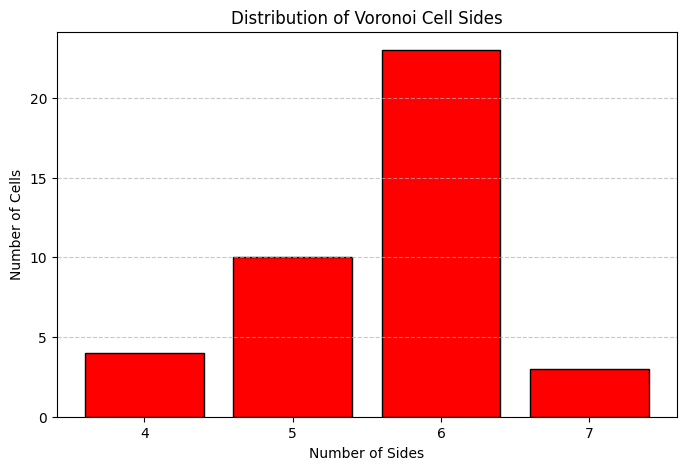

In [16]:
import networkx as nx
import matplotlib.pyplot as plt

# Construct Graph from Voronoi
graph = nx.Graph()
for i, region in enumerate(vor.regions):
    if -1 in region or len(region) == 0:
        continue
    graph.add_node(i, sides=len(region))

# Extract Number of Hexagonal Cells
hexagonal_cells = [n for n, attr in graph.nodes(data=True) if attr['sides'] == 6]
hexagonality_ratio = len(hexagonal_cells) / len(graph.nodes)

print(f'Hexagonality Ratio: {hexagonality_ratio:.2f}')

# Count the number of cells for each number of sides
side_counts = {}
for n, attr in graph.nodes(data=True):
    sides = attr['sides']
    if sides in side_counts:
        side_counts[sides] += 1
    else:
        side_counts[sides] = 1

# Sort the sides for better visualization
sorted_sides = sorted(side_counts.keys())

# Create bar plot
plt.figure(figsize=(8, 5))
plt.bar(sorted_sides, [side_counts[s] for s in sorted_sides], color='red', edgecolor='black')
plt.xlabel('Number of Sides')
plt.ylabel('Number of Cells')
plt.title('Distribution of Voronoi Cell Sides')
plt.xticks(sorted_sides)  # Ensure all side numbers are shown on the x-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

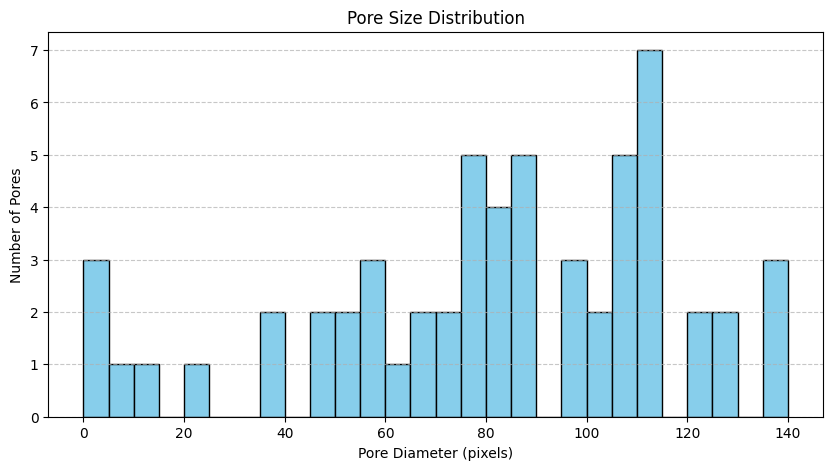

In [44]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load SEM Image in Grayscale
image = cv2.imread('sample2A.jpg', cv2.IMREAD_GRAYSCALE)
if image is None:
    raise ValueError("Image not found. Check the file path.")

# Step 1: Preprocess the Image (Thresholding and Cleaning)
_, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
cleaned_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)

# Step 2: Find Contours of Pores
contours, _ = cv2.findContours(cleaned_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Step 3: Calculate Pore Diameters
pore_diameters = []
for contour in contours:
    area = cv2.contourArea(contour)
    equivalent_diameter = 2 * np.sqrt(area / np.pi)  # Diameter of a circle with the same area
    pore_diameters.append(equivalent_diameter)

# Step 4: Bin the Pore Diameters for the Bar Chart
# Define bin edges (adjust based on your pore size range)
bin_edges = np.arange(0, max(pore_diameters) + 5, 5)  # Bins of 5 units (e.g., pixels)
hist, bin_edges = np.histogram(pore_diameters, bins=bin_edges)

# Step 5: Plot the Bar Chart
plt.figure(figsize=(10, 5))
plt.bar(bin_edges[:-1], hist, width=5, align='edge', color='skyblue', edgecolor='black')
plt.xlabel('Pore Diameter (pixels)')
plt.ylabel('Number of Pores')
plt.title('Pore Size Distribution')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()